# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [64]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [65]:
df = pd.read_csv('../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

In [67]:
print(df['ACTION'].mean())

0.9421099209618847


In [68]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [69]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [70]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [71]:
display(classification_report(y_test, y_pred))

'              precision    recall  f1-score   support\n\n           0       0.22      0.03      0.05      1534\n           1       0.94      0.99      0.97     24682\n\n    accuracy                           0.94     26216\n   macro avg       0.58      0.51      0.51     26216\nweighted avg       0.90      0.94      0.91     26216\n'

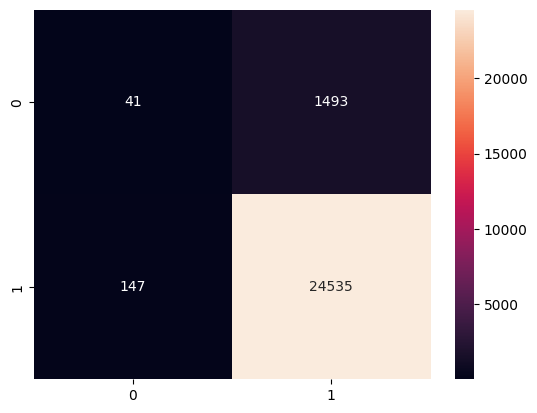

In [72]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [73]:
p_values = [1, 2, 4, 6]
for p in p_values:
    knn = KNeighborsClassifier(n_neighbors=10, p=p)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
    print(f"p={p}: F1 = {scores.mean():.3f} ± {scores.std():.3f}")

p=1: F1 = 0.971 ± 0.000
p=2: F1 = 0.972 ± 0.000
p=4: F1 = 0.971 ± 0.000
p=6: F1 = 0.971 ± 0.000


При p=2 получаем максимум по метрике

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [74]:
def add_counter_features(df_train, df_test, y_train, n_folds=3):
    data_train = pd.DataFrame(index=df_train.index)
    data_test = pd.DataFrame(index=df_test.index)
    
    for col in df_train.columns:
        # Для теста: используем полный train для подсчета
        train_counts = df_train[col].value_counts()
        train_success = df_train[col].map(y_train.groupby(df_train[col]).sum())
        
        # Для тестовых данных
        counts_test = df_test[col].map(train_counts).fillna(0)
        successes_test = df_test[col].map(train_success).fillna(0)
        
        # Для трейна с фолдингом
        fold_size = len(df_train) // n_folds
        counts = pd.Series(0, index=df_train.index, dtype=float)
        successes = pd.Series(0, index=df_train.index, dtype=float)
        
        for fold in range(n_folds):
            # Разделяем на fold и остальные данные
            start = fold * fold_size
            end = (fold + 1) * fold_size
            mask = np.zeros(len(df_train), dtype=bool)
            mask[start:end] = True
            
            # Считаем counts и successes на остальных фолдах
            train_part = df_train[~mask]
            y_part = y_train[~mask]
            
            fold_counts = train_part[col].value_counts()
            fold_success = y_part.groupby(train_part[col]).sum()
            
            counts.loc[mask] = df_train.loc[mask, col].map(fold_counts).fillna(0)
            successes.loc[mask] = df_train.loc[mask, col].map(fold_success).fillna(0)
        
        # Сглаживание
        smoothed = (successes + 1) / (counts + 2)
        
        # Добавляем признаки
        data_train[f'{col}_count'] = counts
        data_train[f'{col}_success'] = successes
        data_train[f'{col}_smoothed'] = smoothed
        
        data_test[f'{col}_count'] = counts_test
        data_test[f'{col}_success'] = successes_test
        data_test[f'{col}_smoothed'] = (successes_test + 1) / (counts_test + 2)
    
    return data_train, data_test

X_train_count, X_test_count = add_counter_features(X_train, X_test, y_train)

Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [75]:
knn = KNeighborsClassifier(n_neighbors=10, p=2)
scores = cross_val_score(knn, X_train_count, y_train, cv=5, scoring='f1')
print(f"p={2}: F1 = {scores.mean():.3f} ± {scores.std():.3f}")

p=2: F1 = 0.970 ± 0.001


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

In [76]:
# Обучение на новых данных
knn = KNeighborsClassifier(n_neighbors=10, p=2)
knn.fit(X_train_count, y_train)
y_pred_count = knn.predict(X_test_count)

print(classification_report(y_test, y_pred_count))

              precision    recall  f1-score   support

           0       0.56      0.01      0.01      1534
           1       0.94      1.00      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.75      0.50      0.49     26216
weighted avg       0.92      0.94      0.91     26216



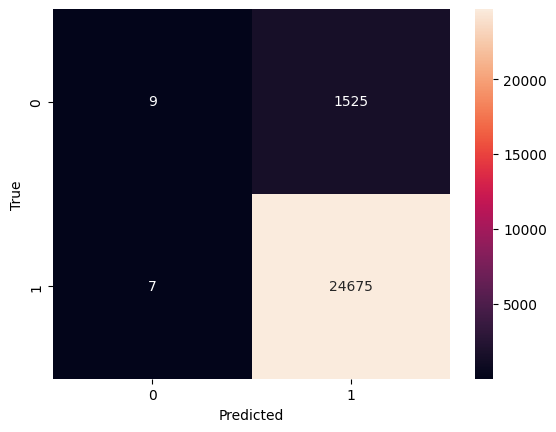

In [77]:
cm = confusion_matrix(y_test, y_pred_count)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

precision для 0 класса стал выше, с 0.03 до 0.56, из-за этого возрасло macro avg с 0.49 до 0.75, остальные метрики без изменений

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [78]:
# Создание парных признаков
from itertools import combinations

df_combo = df.copy()
cols = [c for c in df_combo.columns if c != 'ACTION']
for i, j in combinations(cols, 2):
    df_combo[f'{i}_{j}'] = df_combo[i].astype(str) + '_' + df_combo[j].astype(str)

X_combo = df_combo.drop('ACTION', axis=1)
y_combo = df_combo['ACTION']
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(X_combo, y_combo, test_size=0.8, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10, p=2)
knn.fit(X_train_combo, y_train_combo)
y_pred_combo = knn.predict(X_test_combo)

print(classification_report(y_test_combo, y_pred_combo))

              precision    recall  f1-score   support

           0       0.06      0.00      0.00      1534
           1       0.94      1.00      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.50      0.50      0.49     26216
weighted avg       0.89      0.94      0.91     26216



In [79]:
from sklearn.model_selection import GridSearchCV

# Параметры для поиска
param_grid = {'n_neighbors': [3, 5, 7, 10, 11, 12]}

# Поиск по сетке с кросс-валидацией
grid_search = GridSearchCV(KNeighborsClassifier(p=2), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_combo, y_train_combo)

# Лучший параметр и качество
print(f"Лучшее значение k: {grid_search.best_params_['n_neighbors']}")
print(f"Лучший F1-score на кросс-валидации: {grid_search.best_score_:.3f}")



Лучшее значение k: 11
Лучший F1-score на кросс-валидации: 0.971


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

In [80]:
# Оценка на тестовой выборке с лучшим k
best_knn = grid_search.best_estimator_

y_pred_combo_cv = best_knn.predict(X_test_combo)
print(classification_report(y_test_combo, y_pred_combo_cv))
print(f"F1-score на тестовой выборке: {f1_score(y_test_combo, y_pred_combo_cv):.3f}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1534
           1       0.94      1.00      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.47      0.50      0.48     26216
weighted avg       0.89      0.94      0.91     26216

F1-score на тестовой выборке: 0.970


d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


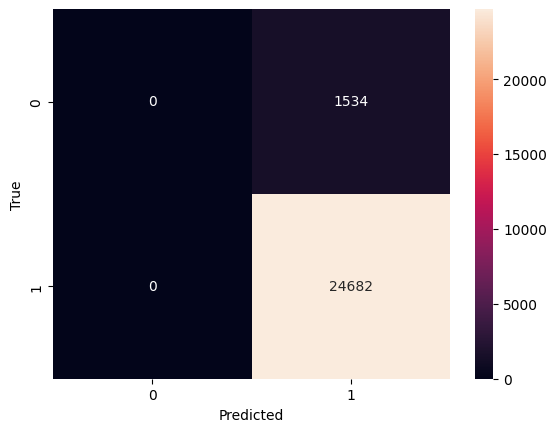

In [81]:
cm = confusion_matrix(y_test_combo, y_pred_combo_cv)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Вывод:** Модель переобучилась и всегда предсказываем класс 1

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [82]:
df_target = df.copy()


In [83]:
data_target = pd.DataFrame(index=df_target.index)
for col_name in df_target.columns:
    if col_name == 'ACTION':
        continue
    mean_encoding = df_target.groupby(col_name)['ACTION'].mean()
    
    data_target[col_name] = df_target[col_name].map(mean_encoding)

In [84]:
# Функция для target encoding
def target_encode(train_df, test_df, target):
    """
    Применяет target encoding к указанным столбцам.
    
    :param train_df: Обучающий набор данных (DataFrame).
    :param test_df: Тестовый набор данных (DataFrame).
    :param target: Целевая переменная (Series).
    :param cols_to_encode: Список столбцов для кодирования.
    :return: Закодированные train_df и test_df.
    """
    encoded_train = pd.DataFrame(index=train_df.index)
    encoded_test = pd.DataFrame(index=test_df.index)
    
    global_mean = target.mean()  # Глобальное среднее целевой переменной
    
    for col in train_df.columns:
        if col == "ACTION":
            continue
        # Вычисляем средние значения для каждой категории в train_df
        mean_encoding = target.groupby(train_df[col]).mean()
        
        # Применяем к train_df
        encoded_train[col] = train_df[col].map(mean_encoding)
        
        # Применяем к test_df
        encoded_test[col] = test_df[col].map(mean_encoding).fillna(global_mean)
    
    
    return encoded_train, encoded_test


# Применяем target encoding
X_train_encoded, X_test_encoded = target_encode(X_train, X_test, y_train)


In [85]:
# Обучение на новых данных
knn = KNeighborsClassifier(n_neighbors=10, p=2)
knn.fit(X_train_encoded, y_train)
y_pred_count = knn.predict(X_test_encoded)

print(classification_report(y_test, y_pred_count))

              precision    recall  f1-score   support

           0       0.29      0.16      0.20      1534
           1       0.95      0.98      0.96     24682

    accuracy                           0.93     26216
   macro avg       0.62      0.57      0.58     26216
weighted avg       0.91      0.93      0.92     26216



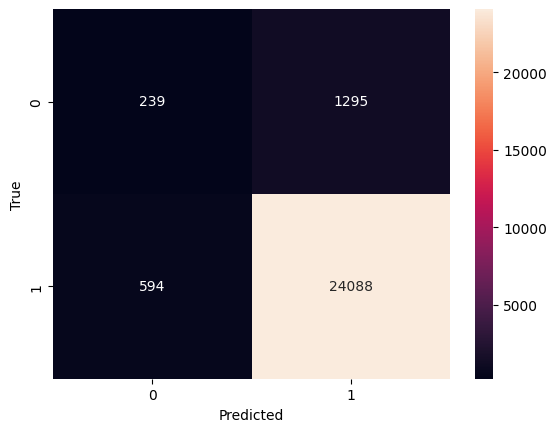

In [86]:
cm = confusion_matrix(y_test, y_pred_count)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Вывод:** Target encode показал лучшие метрики